# Chance-constrained programming: portfolio optimization example

In [18]:
# ENV["GUROBI_HOME"] = "/Library/gurobi952/macos_universal2/"
# # import Pkg
# Pkg.add("Gurobi")
# Pkg.build("Gurobi")
# Pkg.add("Dates")
# Pkg.add("CSV")
# Pkg.add("DataFrames")

   Resolving package versions...


    Updating `~/.julia/environments/v1.9/Project.toml`
⌃ [2e9cd046] + Gurobi v0.11.3
    Updating `~/.julia/environments/v1.9/Manifest.toml`
⌃

 [2e9cd046] + Gurobi v0.11.3
        Info Packages marked with ⌃ have new versions available and may be upgradable.


    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/87c018cbd2fd33e6d2462d486abee53a27c91c91/build.log`


In [1]:
using LinearAlgebra
using JuMP
using HiGHS, Gurobi
using Distributions
using Random
using CSV, DataFramesMeta
using Dates
using Statistics
using Plots

## HW2

Sample Average Approximation Method for Chance Constrained Programming : Theory and Applications”, 2009, Section 3, en s ́electionnant 10 actifs depuis la base de donn ́ees disponible sur Kaggle `a l’adresse https: //www.kaggle.com/datasets/jacksoncrow/stock-market-dataset.

Note : vous pouvez partir de https://www.kaggle.com/code/artemburenok/ stock-analysis-monte-carlo-build-portfolio pour analyser les donn ́ees.

Adapted from Stephen Boyd and Lieven Vandenberghe, "Convex Optimization", Cambridge University Press, 2004, Section 4.7.6, p. 187.

We consider an investiment portfolio with $n$ assets and random returns, except the last one. We assume that the $n-1$ first returns follow a multivariate distribution with known mean and covariance matrix. The last asset is a risk-free investment product, with a fixed return.

The assets characteristics are detailed below.

In [131]:
company_list = ["CSCO", "UNT", "SBGI", "UFCS", "GFED", "AIRT", "SITC", "NXN", "TRNS", "NTZ"]
n = length(company_list)
Random.seed!(42)

TaskLocalRNG()

## Data Pipeline

### Get the monthly return

In [107]:
monthly_path = "../data/clean/monthly/"
companies = Dict{String, DataFrame}()
for c in company_list
    fn = monthly_path * c * ".csv"
    companies[c] = CSV.read(fn, DataFrame, dateformat="yyyy-mm-dd")
end

### Get Clean Data

In [42]:
dir_path = "../data/clean/"
companies = Dict{String, DataFrame}()
# companies = Dict{}()
for company in company_list
    fn = dir_path * company * ".csv"
    companies[company] = CSV.read(fn, DataFrame)
end

## Additional Functions

In [4]:
function calc_mean_cov(returns_N)
    # Calculate mean and covariance

    company_list = collect(keys(companies))
    max_N = size(companies[company_list[1]])[1]

    # if N == 0
    #     N = max_N
    # end

    μ = zeros(length(company_list))
    Σ = zeros(length(company_list), length(company_list))
    
    for (i, company) in enumerate(company_list)

        μ[i] = mean(returns_N[company])

        for (j, company2) in enumerate(company_list)
            Σ[i, j] = cov(returns_N[company], returns_N[company2])
            if abs(Σ[i, j]) > .99; println("$(company), $(company2)"); end
        end
    end

    return μ, Σ
end

calc_mean_cov (generic function with 1 method)

In [5]:
function select_samples(N, companies, rand_sampling=false, sel=false)
    # Select N samples from companies
    # Return a Dict of Vector{Float64} containing the returns
    companies_N = Dict{String, Vector{Float64}}()
    row_cnt = size(companies[company_list[1]])[1]
    for (c, df) in companies
        if rand_sampling
            idx_N = sample(1:size(df)[1], N; replace = false, ordered = true)
            df_N = df[!, :Return][idx_N]
        elseif sel 
            df_N = df[!, :Return][row_cnt-(N-1):row_cnt]
        else
            df_N = df[!, :Return]
        end
        companies_N[c] = df_N

    end
    return companies_N
end

select_samples (generic function with 3 methods)

In [6]:
# Estimate the probability to have a negative return and the resulting expected shortfall.
function expectedshortfall(p:: Vector, d:: Distribution, v::Float64 = 1, M:: Int = 1000000) # M = 1000000
    
    loss = 0
    vloss = 0
    for i = 1:M
        ξ = rand(d)  #[rand(d); μ[n]]
        ret = dot(p, ξ)
        if ret < v
            loss += 1
            vloss += ret
        end
    end

    return loss/M, vloss/loss
end
function ind(v::Float64, val::Float64)
    if v < val
        return 1
    else
        return 0
    end
end

ind (generic function with 1 method)

In [119]:
for (c, df) in companies
    df[!, :Return] = df[!, :Return] .+ 1
    companies[c] = df
end
companies["CSCO"][1:5, :]

,Date,Return
,Date,Float64
1,1995-06-30,1.00737
2,1995-07-31,1.00537
3,1995-08-31,1.00765
4,1995-09-30,1.0028
5,1995-10-31,1.00582


## Model 1/7
SAA with
- Normal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)

#

### Gamma = 0
Model

In [142]:
company_list = collect(keys(returns_N))
length(returns_N[company_list[1]])

10

In [147]:
function gamma_0_model(nu, μ, returns_N)
    company_list = collect(keys(returns_N))
    N = length(returns_N[company_list[1]])

    m = Model(HiGHS.Optimizer)
    @variable(m, p[1:n] >= -.05)
    @constraint(m, sum(p[i] for i = 1:n) <= 1)
    # @constraint  
    @objective(m, Max, sum(p[i]*μ[i] for i = 1:n))

    for k in 1:N
        @constraint(m, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) >= nu)
    end
    optimize!(m)
    
    return objective_value(m), value.(p)
end

gamma_0_model (generic function with 1 method)

### Normal Run

In [152]:
γ = 0.00
nu = .98

μ, Σ = calc_mean_cov(select_samples(0, companies, false, false))
d = MvNormal(μ, Σ)

Ns = sort([collect(30:10:200); 183])
loss_probs = zeros(length(Ns))
objective_vals = zeros(length(Ns))

for (i, N) in enumerate(Ns)
    returns_N = select_samples(N, companies, true, true)
    # MODEL
    obj_val, p = gamma_0_model(nu, μ, returns_N)
 
    objective_vals[i] = obj_val
    loss_probs[i], _ = expectedshortfall(p, d, nu)
end
c = collect(1.0:1:length(Ns))

theme(:ggplot2)
scatter(objective_vals, (1 .- loss_probs), zcolor=c, marker=:circle, xlabel="Objective Function Value", ylabel="Prob of Loss", zlabel="N", legend=false)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
31 rows, 10 cols, 310 nonzeros
31 rows, 10 cols, 310 nonzeros
Presolve : Reductions: rows 31(-0); columns 10(-0); elements 310(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0005177829e+01 Ph1: 31(280.372); Du: 10(10.0052) 0s
          1     1.0017887775e+00 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  1.0017887775e+00
HiGHS run time      :          0.00
Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
41 rows, 10 cols, 410 nonzeros
41 rows, 10 cols, 410 nonzeros
Presolve : Reductions: rows 41(-0); columns 10(-0); elements 410(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simpl

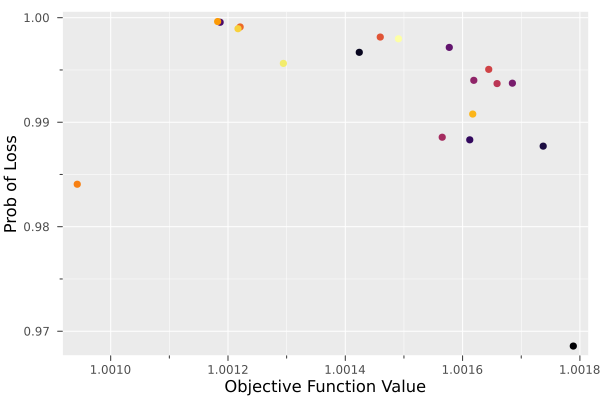

In [151]:
γ = 0.00
nu = .98

μ, Σ = calc_mean_cov(select_samples(0, companies, false, false))
d = MvNormal(μ, Σ)

Ns = sort([collect(30:10:200); 183])
loss_probs = zeros(length(Ns))
objective_vals = zeros(length(Ns))

for (i, N) in enumerate(Ns)
    returns_N = select_samples(N, companies, true, true)
    # MODEL
    m = Model(HiGHS.Optimizer)
    @variable(m, p[1:n] >= -.05)
    @constraint(m, sum(p[i] for i = 1:n) <= 1)
    # @constraint  
    @objective(m, Max, sum(p[i]*μ[i] for i = 1:n))

    for k in 1:N
        @constraint(m, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) >= nu)
    end

    # @constraint(m, )
    optimize!(m)

    objective_vals[i] = objective_value(m)
    loss_probs[i], _ = expectedshortfall(value.(p), d, nu)
end
c = collect(1.0:1:length(Ns))

theme(:ggplot2)
scatter(objective_vals, (1 .- loss_probs), zcolor=c, marker=:circle, xlabel="Objective Function Value", ylabel="Prob of Loss", zlabel="N", legend=false)

In [133]:
println(objective_vals)
println(loss_probs)

[1.0017887774764243, 1.0017824761219467, 1.0017576633012026, 1.0017328469241942, 1.0016794486856668, 1.0017304347953342, 1.0017457208077212, 1.0017421912332094, 1.0014878533458766, 1.0016524907958397, 1.001713906751272, 1.00171498523659, 1.001709611005171, 1.00171098285944, 1.0017150535426067, 1.0017229235581073, 1.0017099329139547, 1.0017153794433666, 1.0016946580043817]
[0.031458, 0.028137, 0.017851, 0.011503, 0.006014, 0.011016, 0.014537, 0.013789, 0.002831, 0.006526, 0.015486, 0.00856, 0.007968, 0.008046, 0.008621, 0.00964, 0.007948, 0.008434, 0.006521]


## Model 2/7
SAA with
- LogNormal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)

In [82]:
exp_col(v) = [exp(x) for x in v]

exp_col (generic function with 1 method)

In [134]:
companies["CSCO"][1:5, :]

,Date,Return
,Date,Float64
1,1995-06-30,1.0074
2,1995-07-31,1.00538
3,1995-08-31,1.00768
4,1995-09-30,1.0028
5,1995-10-31,1.00583


In [125]:

log_companies["CSCO"][1:5, :]

,Date,Return
,Date,Float64
1,1995-06-30,1.00737
2,1995-07-31,1.00537
3,1995-08-31,1.00765
4,1995-09-30,1.0028
5,1995-10-31,1.00582


In [127]:
# Convert the data with log normal transformation
log_companies = Dict{String, DataFrame}()
for (c, df) in companies
#     println(df[1:5, :])
#     println(df[!, :Return] .- 1)
    ndf = df[!, :Return] .- 1
    df[!, :Return] = exp_col(ndf)
    # println(df[1:5, :])
    log_companies[c] = df
end

Dict{String, Vector{Float64}} with 10 entries:
  "UNT"  => [1.00182, 0.998204, 1.00129, 1.00404, 1.00189, 1.0005, 1.01519, 0.9…
  "NTZ"  => [1.00334, 0.996904, 0.999773, 1.00099, 1.00157, 1.00098, 1.00505, 1…
  "UFCS" => [1.00336, 1.01708, 1.00377, 0.995189, 1.00507, 0.986791, 0.999212, …
  "GFED" => [0.997065, 1.00707, 0.99851, 1.00144, 0.999992, 1.00009, 0.999533, …
  "TRNS" => [0.992344, 0.996434, 0.999039, 1.00635, 1.00266, 1.00113, 0.999073,…
  "CSCO" => [1.00437, 0.993762, 1.00075, 1.00949, 0.987073, 1.00968, 0.99366, 0…
  "SITC" => [1.00045, 1.00151, 1.00326, 1.00716, 0.993924, 0.994391, 1.00091, 1…
  "NXN"  => [0.998668, 1.00136, 1.00125, 0.999683, 0.999192, 1.0003, 1.00045, 1…
  "SBGI" => [1.0046, 0.979238, 1.00308, 0.999673, 1.0011, 1.00509, 0.997463, 1.…
  "AIRT" => [0.996831, 0.998175, 0.998667, 1.00251, 0.984118, 1.00292, 1.00084,…

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
31 rows, 10 cols, 310 nonzeros
31 rows, 10 cols, 310 nonzeros
Presolve : Reductions: rows 31(-0); columns 10(-0); elements 310(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0005177829e+01 Ph1: 31(280.027); Du: 10(10.0052) 0s
          1     1.0017887775e+00 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  1.0017887775e+00
HiGHS run time      :          0.00
Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
41 rows, 10 cols, 410 nonzeros
41 rows, 10 cols, 410 nonzeros
Presolve : Reductions: rows 41(-0); columns 10(-0); elements 410(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simpl

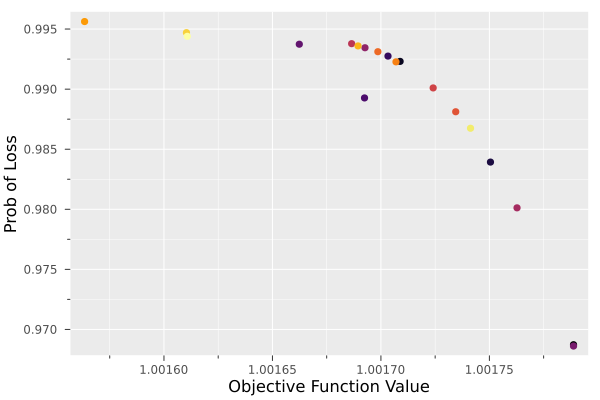

In [136]:
γ = 0.00
nu = .98

μ, Σ = calc_mean_cov(select_samples(0, log_companies, false, false))
d = MvNormal(μ, Σ)

Ns = sort([collect(30:10:200); 183])
loss_probs = zeros(length(Ns))
objective_vals = zeros(length(Ns))

for (i, N) in enumerate(Ns)
    returns_N = select_samples(N, log_companies, true, true)
    # MODEL
    m = Model(HiGHS.Optimizer)
    @variable(m, p[1:n] >= -.05)
    @constraint(m, sum(p[i] for i = 1:n) <= 1)
    # @constraint  
    @objective(m, Max, sum(p[i]*μ[i] for i = 1:n))

    for k in 1:N
        @constraint(m, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) >= nu)
    end

    # @constraint(m, )
    optimize!(m)

    objective_vals[i] = objective_value(m)
    loss_probs[i], _ = expectedshortfall(value.(p), d, nu)
end
c = collect(1.0:1:length(Ns))

theme(:ggplot2)
scatter(objective_vals, (1 .- loss_probs), zcolor=c, marker=:circle, xlabel="Objective Function Value", ylabel="Prob of Loss", zlabel="N", legend=false)